<a href="https://www.kaggle.com/code/alen1211/simple-gan-tensorflow?scriptVersionId=296531501" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 # GAN for MNIST (TensorFlow)



**Why this works better:**
- Simpler architecture = faster, more stable training
- Larger batch size (2048) = better gradient estimates
- Uses logits (no sigmoid) = better numerical stability
- Combined discriminator loss = balanced training

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time



## 1. Load MNIST Data

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize to [-1, 1] for tanh
x_train = (x_train.astype('float32') - 127.5) / 127.5

# Flatten to (60000, 784)
x_train = x_train.reshape(x_train.shape[0], -1)

print(f"Training samples: {x_train.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")
print(f"Value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

Training samples: 60000
Image shape: (784,)
Value range: [-1.00, 1.00]


## 2. Build Models

**Discriminator:** `784 → Dense(128) → LeakyReLU → Dropout → Dense(1)`  
**Generator:** `100 → Dense(128) → LeakyReLU → Dropout → Dense(784) → Tanh`

In [9]:
def build_discriminator(image_dim=784):
    model = keras.Sequential([
        layers.Input(shape=(image_dim,)),
        layers.Dense(128),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.5),
        layers.Dense(1)  # Logits (no sigmoid!)
    ], name='discriminator')
    return model


def build_generator(latent_dim=100, image_dim=784):
    model = keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(128),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.5),
        layers.Dense(image_dim),
        layers.Activation('tanh')
    ], name='generator')
    return model


LATENT_DIM = 100
IMAGE_DIM = 28 * 28

generator = build_generator(LATENT_DIM, IMAGE_DIM)
discriminator = build_discriminator(IMAGE_DIM)

generator.summary()
discriminator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,064 (445.56 KB)

 Trainable params: 114,064 (445.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training Function

In [10]:
def train_gan(num_epochs, generator, discriminator, latent_dim, 
              batch_size=2048, learning_rate=0.0002, beta_1=0.5):
    
    # Loss with logits (matches PyTorch BCEWithLogitsLoss)
    loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Optimizers
    gen_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    disc_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    
    # Dataset
    dataset = tf.data.Dataset.from_tensor_slices(x_train)
    dataset = dataset.shuffle(60000).batch(batch_size)
    
    # Fixed noise for visualization
    fixed_noise = tf.random.normal([64, latent_dim])
    
    # Metrics
    log_dict = {
        'gen_loss': [],
        'disc_loss': [],
        'disc_real_acc': [],
        'disc_fake_acc': []
    }
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        epoch_metrics = {'gen': [], 'disc': [], 'real_acc': [], 'fake_acc': []}
        
        for batch_idx, real_images in enumerate(dataset):
            batch_size_current = real_images.shape[0]
            
            real_labels = tf.ones((batch_size_current, 1))
            fake_labels = tf.zeros((batch_size_current, 1))
            
            # Train Discriminator
            with tf.GradientTape() as disc_tape:
                # Real images
                disc_pred_real = discriminator(real_images, training=True)
                real_loss = loss_fn(real_labels, disc_pred_real)
                
                # Fake images
                noise = tf.random.normal([batch_size_current, latent_dim])
                fake_images = generator(noise, training=True)
                disc_pred_fake = discriminator(fake_images, training=True)
                fake_loss = loss_fn(fake_labels, disc_pred_fake)
                
                # Combined loss
                disc_loss = 0.5 * (real_loss + fake_loss)
            
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
            
            # Train Generator
            with tf.GradientTape() as gen_tape:
                noise = tf.random.normal([batch_size_current, latent_dim])
                fake_images = generator(noise, training=True)
                disc_pred_fake = discriminator(fake_images, training=True)
                gen_loss = loss_fn(real_labels, disc_pred_fake)  # Flipped labels
            
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            
            # Calculate accuracies
            acc_real = tf.reduce_mean(tf.cast(disc_pred_real > 0, tf.float32)) * 100
            acc_fake = tf.reduce_mean(tf.cast(disc_pred_fake <= 0, tf.float32)) * 100
            
            # Log metrics
            epoch_metrics['gen'].append(gen_loss.numpy())
            epoch_metrics['disc'].append(disc_loss.numpy())
            epoch_metrics['real_acc'].append(acc_real.numpy())
            epoch_metrics['fake_acc'].append(acc_fake.numpy())
            
            log_dict['gen_loss'].append(gen_loss.numpy())
            log_dict['disc_loss'].append(disc_loss.numpy())
            log_dict['disc_real_acc'].append(acc_real.numpy())
            log_dict['disc_fake_acc'].append(acc_fake.numpy())
        
        # Epoch summary
        print(f"  Gen Loss: {np.mean(epoch_metrics['gen']):.4f} | "
              f"Disc Loss: {np.mean(epoch_metrics['disc']):.4f} | "
              f"D(real): {np.mean(epoch_metrics['real_acc']):.1f}% | "
              f"D(fake): {np.mean(epoch_metrics['fake_acc']):.1f}%")
        
        # Visualize every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_images(generator, epoch + 1, fixed_noise)
    
    print(f"\nTotal time: {(time.time() - start_time)/60:.2f} min")
    return log_dict


def generate_images(model, epoch, noise):
    predictions = model(noise, training=False).numpy()
    predictions = predictions.reshape(-1, 28, 28) * 0.5 + 0.5
    
    fig = plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(predictions[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()



## 4. Start Training 


Epoch 1/100
  Gen Loss: 0.3924 | Disc Loss: 0.7230 | D(real): 99.3% | D(fake): 10.4%

Epoch 2/100
  Gen Loss: 0.5078 | Disc Loss: 0.5880 | D(real): 100.0% | D(fake): 21.0%

Epoch 3/100
  Gen Loss: 0.6113 | Disc Loss: 0.5106 | D(real): 99.9% | D(fake): 33.1%

Epoch 4/100
  Gen Loss: 0.6227 | Disc Loss: 0.5086 | D(real): 99.6% | D(fake): 35.0%

Epoch 5/100
  Gen Loss: 0.6585 | Disc Loss: 0.4967 | D(real): 99.2% | D(fake): 39.8%

Epoch 6/100
  Gen Loss: 0.6914 | Disc Loss: 0.4935 | D(real): 98.7% | D(fake): 44.2%

Epoch 7/100
  Gen Loss: 0.7425 | Disc Loss: 0.4711 | D(real): 98.2% | D(fake): 50.2%

Epoch 8/100
  Gen Loss: 0.7812 | Disc Loss: 0.4637 | D(real): 97.9% | D(fake): 55.1%

Epoch 9/100
  Gen Loss: 0.7932 | Disc Loss: 0.4646 | D(real): 97.0% | D(fake): 56.6%

Epoch 10/100
  Gen Loss: 0.7763 | Disc Loss: 0.4874 | D(real): 95.8% | D(fake): 54.9%


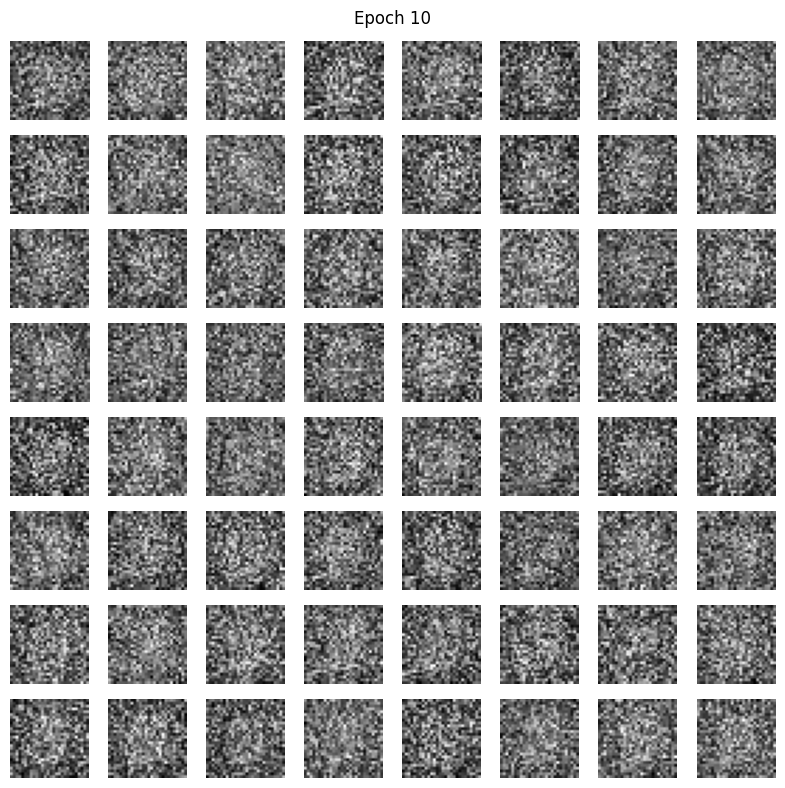


Epoch 11/100
  Gen Loss: 0.8015 | Disc Loss: 0.4845 | D(real): 95.1% | D(fake): 57.8%

Epoch 12/100
  Gen Loss: 0.8112 | Disc Loss: 0.4871 | D(real): 94.7% | D(fake): 58.7%

Epoch 13/100
  Gen Loss: 0.7876 | Disc Loss: 0.5184 | D(real): 93.4% | D(fake): 55.8%

Epoch 14/100
  Gen Loss: 0.7832 | Disc Loss: 0.5259 | D(real): 92.7% | D(fake): 55.4%

Epoch 15/100
  Gen Loss: 0.8236 | Disc Loss: 0.5186 | D(real): 92.2% | D(fake): 59.4%

Epoch 16/100
  Gen Loss: 0.8015 | Disc Loss: 0.5368 | D(real): 91.3% | D(fake): 56.9%

Epoch 17/100
  Gen Loss: 0.7857 | Disc Loss: 0.5413 | D(real): 91.5% | D(fake): 56.2%

Epoch 18/100
  Gen Loss: 0.7991 | Disc Loss: 0.5297 | D(real): 91.8% | D(fake): 58.3%

Epoch 19/100
  Gen Loss: 0.7917 | Disc Loss: 0.5528 | D(real): 90.6% | D(fake): 56.7%

Epoch 20/100
  Gen Loss: 0.7700 | Disc Loss: 0.5754 | D(real): 89.3% | D(fake): 54.4%


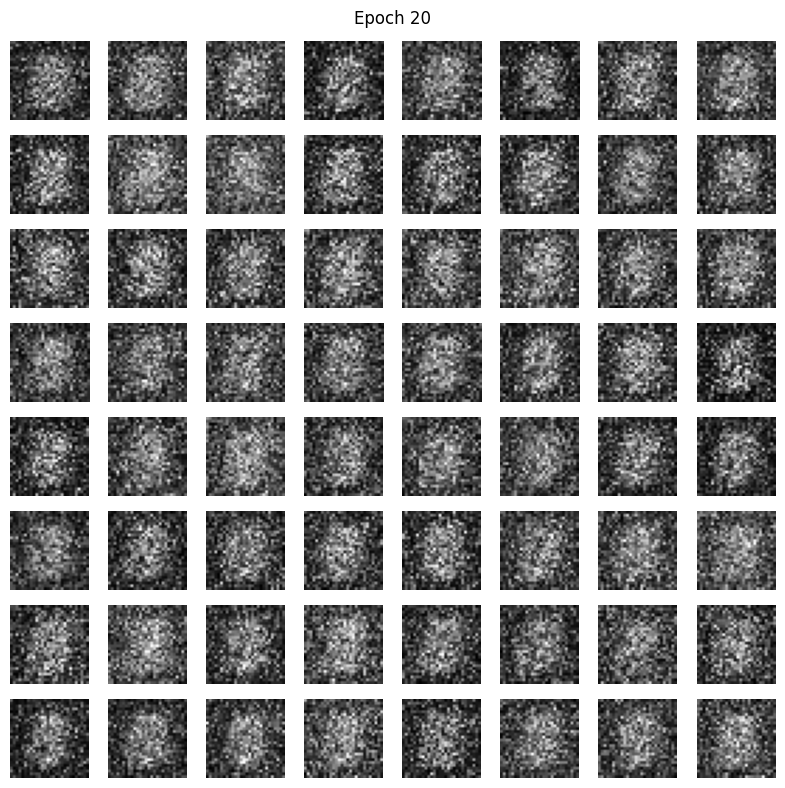


Epoch 21/100
  Gen Loss: 0.8022 | Disc Loss: 0.5483 | D(real): 90.4% | D(fake): 59.4%

Epoch 22/100
  Gen Loss: 0.7691 | Disc Loss: 0.5620 | D(real): 90.4% | D(fake): 55.6%

Epoch 23/100
  Gen Loss: 0.7810 | Disc Loss: 0.5647 | D(real): 89.1% | D(fake): 57.1%

Epoch 24/100
  Gen Loss: 0.7874 | Disc Loss: 0.5759 | D(real): 88.0% | D(fake): 57.9%

Epoch 25/100
  Gen Loss: 0.7717 | Disc Loss: 0.5826 | D(real): 88.4% | D(fake): 56.3%

Epoch 26/100
  Gen Loss: 0.7842 | Disc Loss: 0.5661 | D(real): 89.7% | D(fake): 58.5%

Epoch 27/100
  Gen Loss: 0.7740 | Disc Loss: 0.5616 | D(real): 90.9% | D(fake): 58.5%

Epoch 28/100
  Gen Loss: 0.7586 | Disc Loss: 0.5696 | D(real): 90.7% | D(fake): 57.1%

Epoch 29/100
  Gen Loss: 0.7590 | Disc Loss: 0.5722 | D(real): 89.9% | D(fake): 57.2%

Epoch 30/100
  Gen Loss: 0.7797 | Disc Loss: 0.5684 | D(real): 88.6% | D(fake): 60.1%


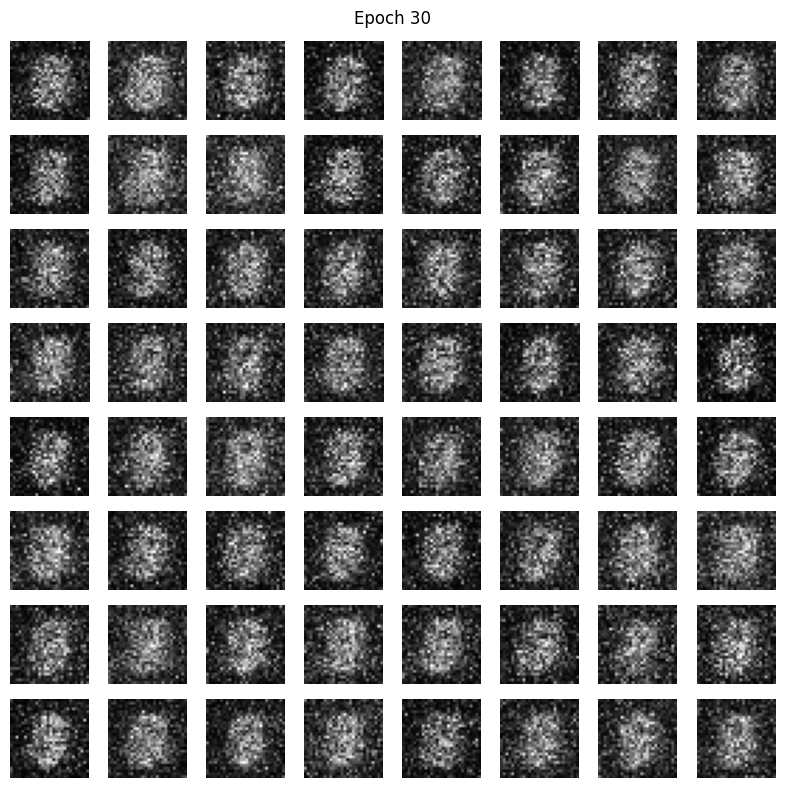


Epoch 31/100
  Gen Loss: 0.8331 | Disc Loss: 0.5447 | D(real): 87.2% | D(fake): 68.4%

Epoch 32/100
  Gen Loss: 0.8189 | Disc Loss: 0.5558 | D(real): 85.2% | D(fake): 67.3%

Epoch 33/100
  Gen Loss: 0.8651 | Disc Loss: 0.5266 | D(real): 86.7% | D(fake): 75.4%

Epoch 34/100
  Gen Loss: 0.9165 | Disc Loss: 0.5003 | D(real): 87.8% | D(fake): 79.5%

Epoch 35/100
  Gen Loss: 0.9026 | Disc Loss: 0.5045 | D(real): 86.6% | D(fake): 77.9%

Epoch 36/100
  Gen Loss: 0.9376 | Disc Loss: 0.4808 | D(real): 86.7% | D(fake): 84.4%

Epoch 37/100
  Gen Loss: 0.9707 | Disc Loss: 0.4721 | D(real): 85.0% | D(fake): 87.0%

Epoch 38/100
  Gen Loss: 1.0449 | Disc Loss: 0.4428 | D(real): 85.5% | D(fake): 90.5%

Epoch 39/100
  Gen Loss: 1.0628 | Disc Loss: 0.4393 | D(real): 85.2% | D(fake): 90.8%

Epoch 40/100
  Gen Loss: 1.0657 | Disc Loss: 0.4464 | D(real): 84.1% | D(fake): 89.2%


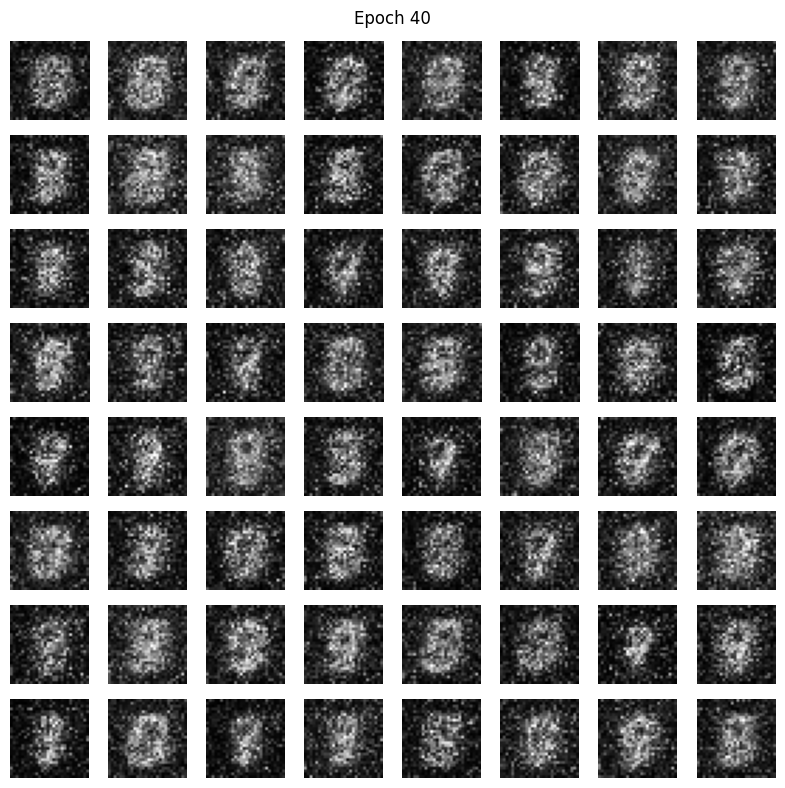


Epoch 41/100
  Gen Loss: 1.1099 | Disc Loss: 0.4349 | D(real): 84.1% | D(fake): 89.5%

Epoch 42/100
  Gen Loss: 1.1219 | Disc Loss: 0.4341 | D(real): 84.2% | D(fake): 88.3%

Epoch 43/100
  Gen Loss: 1.1138 | Disc Loss: 0.4507 | D(real): 82.3% | D(fake): 86.5%

Epoch 44/100
  Gen Loss: 1.0896 | Disc Loss: 0.4585 | D(real): 82.2% | D(fake): 84.8%

Epoch 45/100
  Gen Loss: 1.0752 | Disc Loss: 0.4589 | D(real): 82.6% | D(fake): 84.6%

Epoch 46/100
  Gen Loss: 1.0900 | Disc Loss: 0.4665 | D(real): 80.9% | D(fake): 83.9%

Epoch 47/100
  Gen Loss: 1.0581 | Disc Loss: 0.4874 | D(real): 79.9% | D(fake): 81.7%

Epoch 48/100
  Gen Loss: 1.0811 | Disc Loss: 0.4814 | D(real): 80.4% | D(fake): 81.8%

Epoch 49/100
  Gen Loss: 1.0487 | Disc Loss: 0.4927 | D(real): 80.7% | D(fake): 79.9%

Epoch 50/100
  Gen Loss: 0.9990 | Disc Loss: 0.5083 | D(real): 79.5% | D(fake): 77.9%


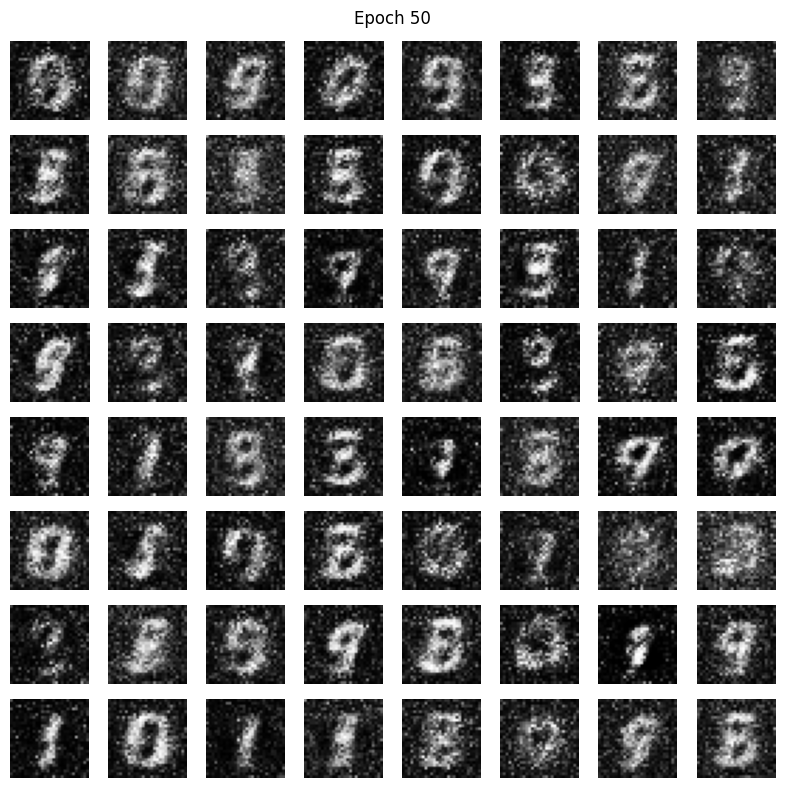


Epoch 51/100
  Gen Loss: 1.0220 | Disc Loss: 0.5101 | D(real): 78.7% | D(fake): 78.9%

Epoch 52/100
  Gen Loss: 1.0462 | Disc Loss: 0.5076 | D(real): 77.6% | D(fake): 79.7%

Epoch 53/100
  Gen Loss: 1.0416 | Disc Loss: 0.5148 | D(real): 77.4% | D(fake): 79.1%

Epoch 54/100
  Gen Loss: 1.0126 | Disc Loss: 0.5193 | D(real): 77.8% | D(fake): 78.0%

Epoch 55/100
  Gen Loss: 1.0375 | Disc Loss: 0.5055 | D(real): 79.5% | D(fake): 78.9%

Epoch 56/100
  Gen Loss: 1.0012 | Disc Loss: 0.5177 | D(real): 78.8% | D(fake): 77.6%

Epoch 57/100
  Gen Loss: 0.9806 | Disc Loss: 0.5287 | D(real): 77.5% | D(fake): 76.5%

Epoch 58/100
  Gen Loss: 0.9954 | Disc Loss: 0.5231 | D(real): 77.5% | D(fake): 76.8%

Epoch 59/100
  Gen Loss: 0.9939 | Disc Loss: 0.5326 | D(real): 76.8% | D(fake): 76.9%

Epoch 60/100
  Gen Loss: 1.0315 | Disc Loss: 0.5139 | D(real): 78.3% | D(fake): 79.4%


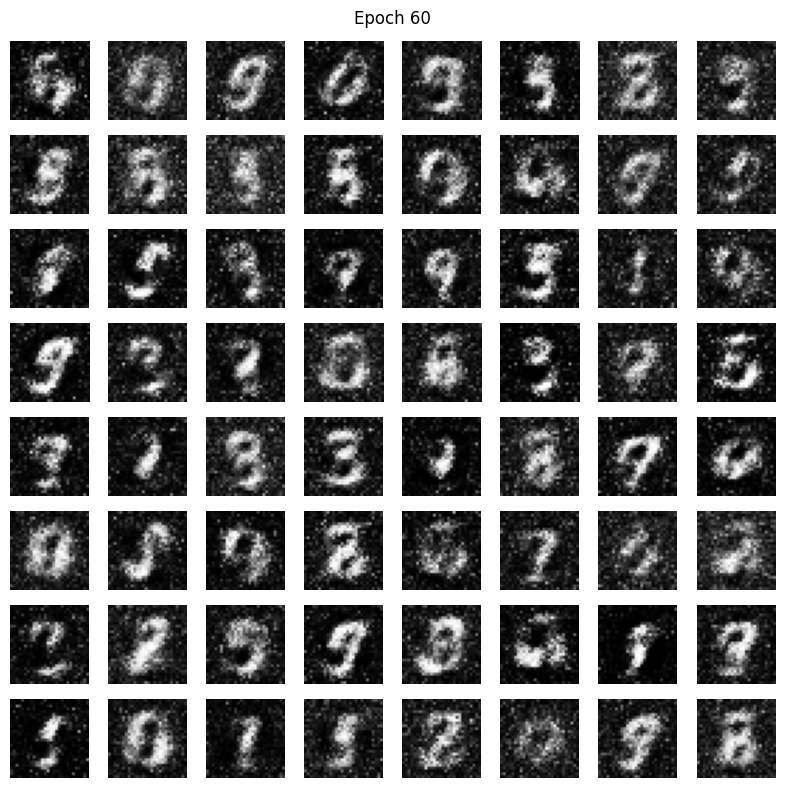


Epoch 61/100
  Gen Loss: 1.0190 | Disc Loss: 0.5062 | D(real): 78.9% | D(fake): 79.7%

Epoch 62/100
  Gen Loss: 1.0259 | Disc Loss: 0.5040 | D(real): 79.0% | D(fake): 80.5%

Epoch 63/100
  Gen Loss: 1.0793 | Disc Loss: 0.4827 | D(real): 79.7% | D(fake): 83.2%

Epoch 64/100
  Gen Loss: 1.0863 | Disc Loss: 0.4653 | D(real): 80.8% | D(fake): 84.6%

Epoch 65/100
  Gen Loss: 1.0919 | Disc Loss: 0.4749 | D(real): 79.8% | D(fake): 84.5%

Epoch 66/100
  Gen Loss: 1.1018 | Disc Loss: 0.4693 | D(real): 79.9% | D(fake): 84.0%

Epoch 67/100
  Gen Loss: 1.0958 | Disc Loss: 0.4710 | D(real): 79.6% | D(fake): 83.3%

Epoch 68/100
  Gen Loss: 1.1171 | Disc Loss: 0.4822 | D(real): 79.1% | D(fake): 82.1%

Epoch 69/100
  Gen Loss: 1.1044 | Disc Loss: 0.4905 | D(real): 77.5% | D(fake): 81.8%

Epoch 70/100
  Gen Loss: 1.0576 | Disc Loss: 0.5063 | D(real): 76.9% | D(fake): 79.4%


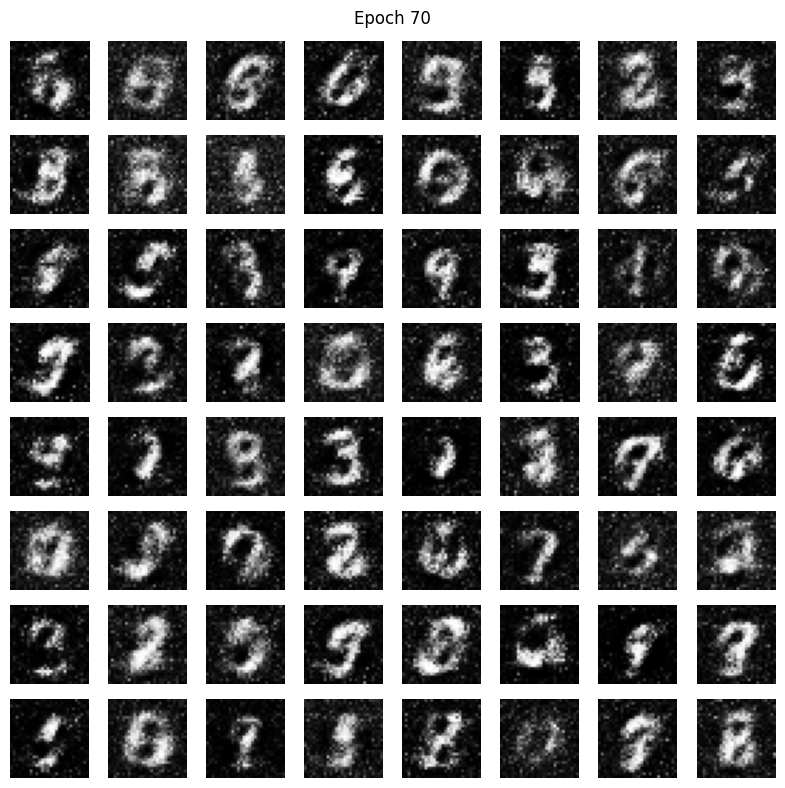


Epoch 71/100
  Gen Loss: 1.0862 | Disc Loss: 0.4993 | D(real): 77.4% | D(fake): 80.2%

Epoch 72/100
  Gen Loss: 1.0502 | Disc Loss: 0.5139 | D(real): 76.8% | D(fake): 78.8%

Epoch 73/100
  Gen Loss: 1.0609 | Disc Loss: 0.4994 | D(real): 77.3% | D(fake): 79.9%

Epoch 74/100
  Gen Loss: 1.0808 | Disc Loss: 0.5129 | D(real): 75.9% | D(fake): 79.2%

Epoch 75/100
  Gen Loss: 1.0730 | Disc Loss: 0.5175 | D(real): 75.0% | D(fake): 77.7%

Epoch 76/100
  Gen Loss: 1.0878 | Disc Loss: 0.5100 | D(real): 76.2% | D(fake): 79.2%

Epoch 77/100
  Gen Loss: 1.0440 | Disc Loss: 0.5282 | D(real): 74.9% | D(fake): 77.5%

Epoch 78/100
  Gen Loss: 1.0296 | Disc Loss: 0.5236 | D(real): 75.4% | D(fake): 77.6%

Epoch 79/100
  Gen Loss: 1.0443 | Disc Loss: 0.5199 | D(real): 75.2% | D(fake): 78.0%

Epoch 80/100
  Gen Loss: 1.0399 | Disc Loss: 0.5268 | D(real): 74.6% | D(fake): 76.4%


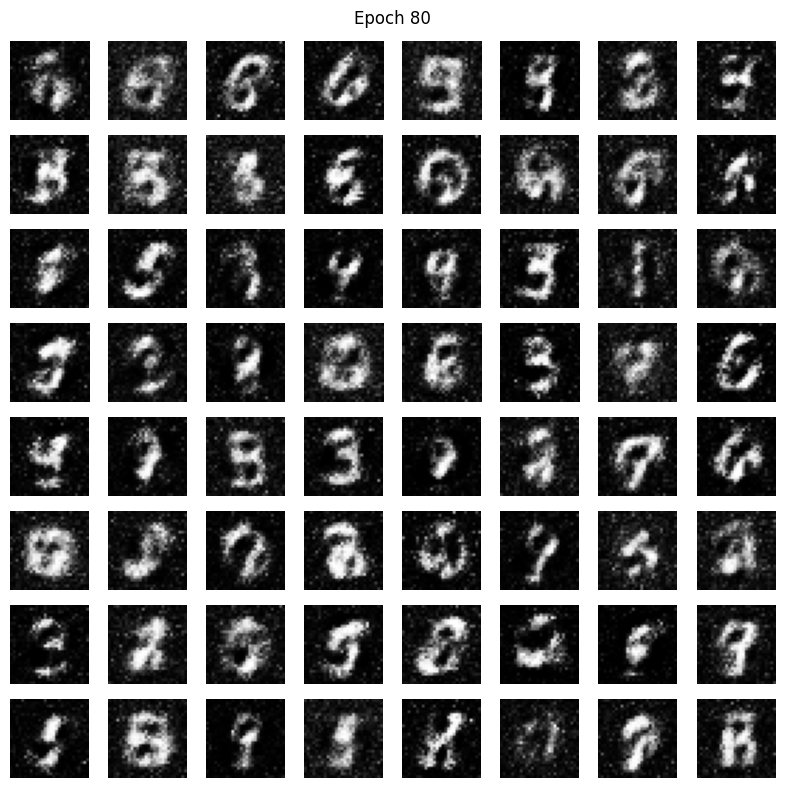


Epoch 81/100
  Gen Loss: 1.0429 | Disc Loss: 0.5381 | D(real): 73.6% | D(fake): 75.7%

Epoch 82/100
  Gen Loss: 1.0372 | Disc Loss: 0.5391 | D(real): 73.3% | D(fake): 75.5%

Epoch 83/100
  Gen Loss: 1.0309 | Disc Loss: 0.5394 | D(real): 73.1% | D(fake): 76.7%

Epoch 84/100
  Gen Loss: 1.0422 | Disc Loss: 0.5304 | D(real): 73.8% | D(fake): 76.3%

Epoch 85/100
  Gen Loss: 1.0303 | Disc Loss: 0.5355 | D(real): 73.7% | D(fake): 76.7%

Epoch 86/100
  Gen Loss: 1.0280 | Disc Loss: 0.5444 | D(real): 72.6% | D(fake): 75.5%

Epoch 87/100
  Gen Loss: 1.0130 | Disc Loss: 0.5419 | D(real): 72.7% | D(fake): 75.2%

Epoch 88/100
  Gen Loss: 1.0308 | Disc Loss: 0.5331 | D(real): 73.4% | D(fake): 76.5%

Epoch 89/100
  Gen Loss: 1.0207 | Disc Loss: 0.5421 | D(real): 73.0% | D(fake): 74.9%

Epoch 90/100
  Gen Loss: 1.0263 | Disc Loss: 0.5368 | D(real): 72.9% | D(fake): 76.1%


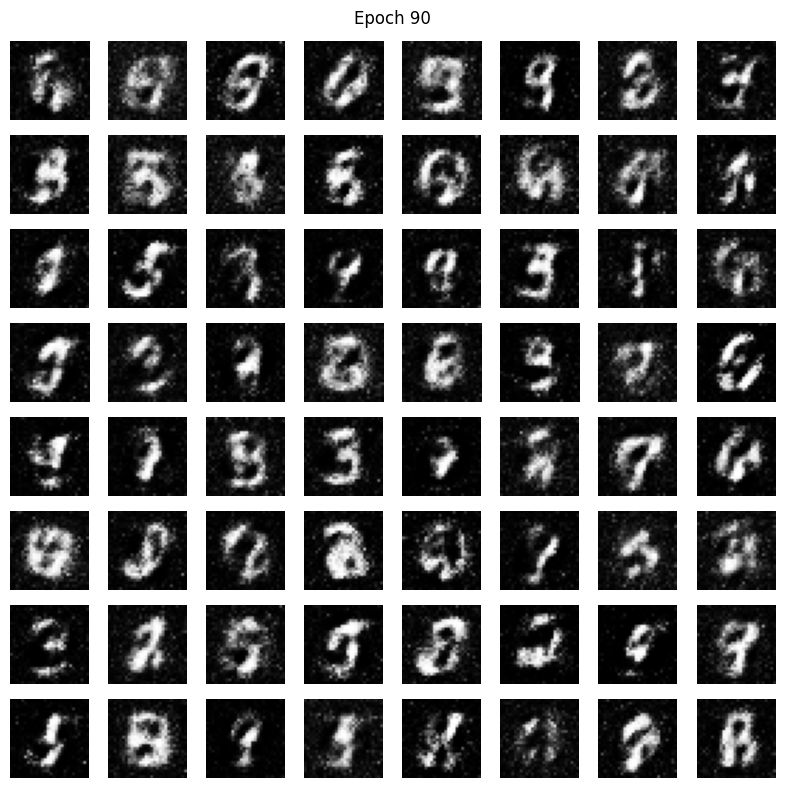


Epoch 91/100
  Gen Loss: 1.0027 | Disc Loss: 0.5505 | D(real): 72.1% | D(fake): 75.2%

Epoch 92/100
  Gen Loss: 1.0060 | Disc Loss: 0.5522 | D(real): 71.4% | D(fake): 74.9%

Epoch 93/100
  Gen Loss: 1.0209 | Disc Loss: 0.5460 | D(real): 72.1% | D(fake): 74.6%

Epoch 94/100
  Gen Loss: 1.0226 | Disc Loss: 0.5503 | D(real): 71.6% | D(fake): 75.1%

Epoch 95/100
  Gen Loss: 1.0168 | Disc Loss: 0.5514 | D(real): 71.0% | D(fake): 74.9%

Epoch 96/100
  Gen Loss: 1.0084 | Disc Loss: 0.5551 | D(real): 71.1% | D(fake): 74.4%

Epoch 97/100
  Gen Loss: 1.0051 | Disc Loss: 0.5555 | D(real): 70.9% | D(fake): 74.8%

Epoch 98/100
  Gen Loss: 1.0120 | Disc Loss: 0.5604 | D(real): 70.6% | D(fake): 74.1%

Epoch 99/100
  Gen Loss: 0.9998 | Disc Loss: 0.5599 | D(real): 70.3% | D(fake): 74.0%

Epoch 100/100
  Gen Loss: 1.0131 | Disc Loss: 0.5563 | D(real): 71.4% | D(fake): 73.9%


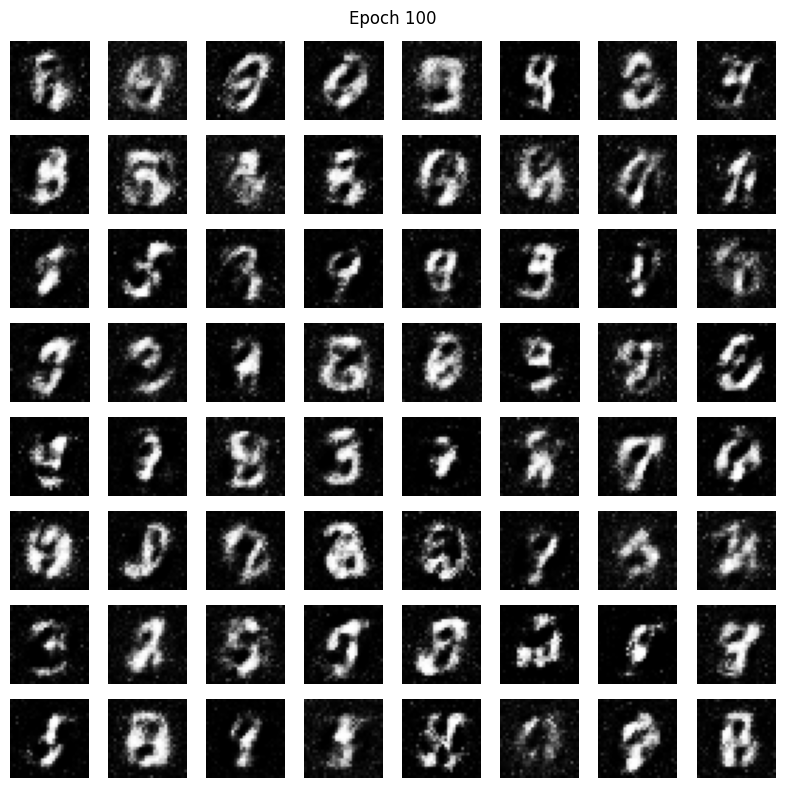


Total time: 5.53 min

✅ Training complete!


In [11]:
log_dict = train_gan(
    num_epochs=100,
    generator=generator,
    discriminator=discriminator,
    latent_dim=LATENT_DIM,
    batch_size=2048,
    learning_rate=0.0002,
    beta_1=0.5
)

print("\n✅ Training complete!")

## 5. Plot Training Metrics

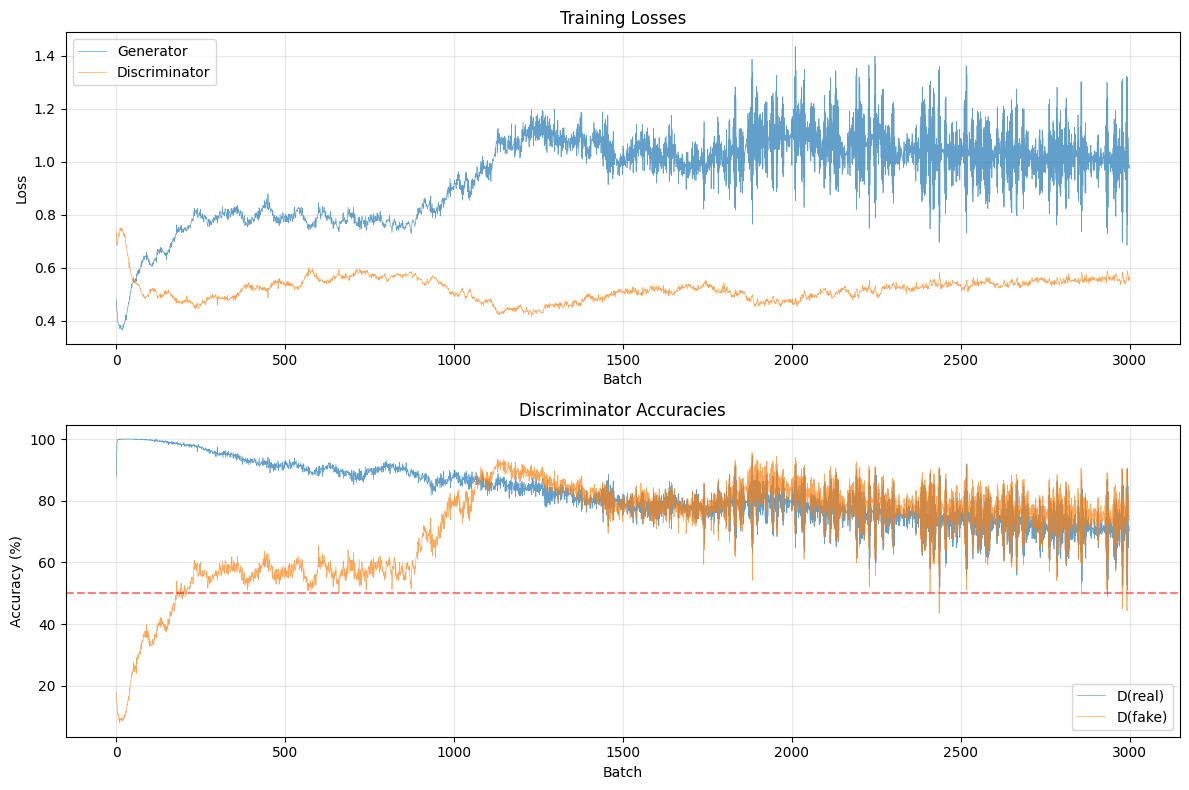

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Losses
axes[0].plot(log_dict['gen_loss'], label='Generator', alpha=0.7, linewidth=0.5)
axes[0].plot(log_dict['disc_loss'], label='Discriminator', alpha=0.7, linewidth=0.5)
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracies
axes[1].plot(log_dict['disc_real_acc'], label='D(real)', alpha=0.7, linewidth=0.5)
axes[1].plot(log_dict['disc_fake_acc'], label='D(fake)', alpha=0.7, linewidth=0.5)
axes[1].axhline(y=50, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Batch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Discriminator Accuracies')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Generate Final Samples

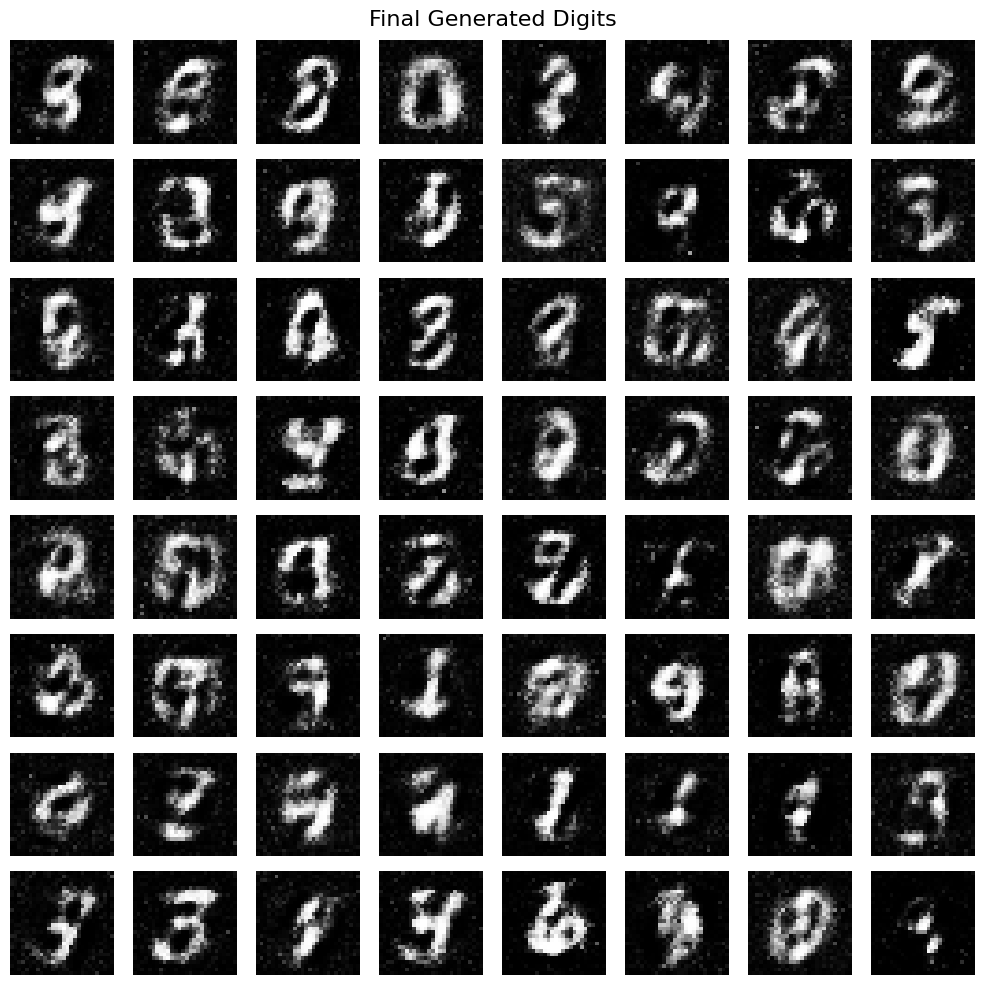

In [13]:
noise = tf.random.normal([64, LATENT_DIM])
generated = generator(noise, training=False).numpy()
generated = generated.reshape(-1, 28, 28) * 0.5 + 0.5

fig = plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Final Generated Digits', fontsize=16)
plt.tight_layout()
plt.show()

## 7. Save Models

In [15]:
generator.save('mnist_generator_simple.h5')
discriminator.save('mnist_discriminator_simple.h5')
print("Models saved!")

Models saved!
